# **Final Project**

For our final project we try to forecast stock price on a given day from a sequence from previous days data.

We will try several models, starting from a simple LSTM adapted from our Lab 2 work.  With some modifications:

* Removing the last linear layer activation function as we are going to do a forecast and not a classification.

* Reshaping the output dimensions so that we can predict as many features as we like.

* Changing the loss function into a MSE lost.


In [4]:
from google.colab import drive
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn.modules import activation
import torch
from torch import nn
import torch.optim as optim

In [5]:
drive.mount('/content/drive')
myDrive = '/content/drive/Shareddrives/Deep_Learning_2024/Final/Data/Mixed_ETF/'

Mounted at /content/drive


In [6]:
file_path = os.path.join(myDrive,'ETF_Data.csv')
data = pd.read_csv(file_path, sep=",", header=0)

Split Data

In [7]:
data.head()

,Date_vaw,Open_vaw,High_vaw,Low_vaw,Close_vaw,Volume_vaw,Open_vcr,High_vcr,Low_vcr,Close_vcr,...,Open_vht,High_vht,Low_vht,Close_vht,Volume_vht,Open_vnq,High_vnq,Low_vnq,Close_vnq,Volume_vnq
0,2005-02-25,54.737,55.614,54.737,55.594,20156,49.021,49.292,49.021,49.255,...,46.707,47.021,46.602,47.021,122102,39.719,40.308,39.719,40.272,39871
1,2005-02-28,55.728,55.728,54.855,55.194,47699,49.274,49.274,49.021,49.183,...,46.800,46.800,46.207,46.476,13375,40.301,40.401,39.749,40.156,72024
2,2005-03-01,55.418,55.640,55.041,55.130,17578,49.403,49.653,49.403,49.653,...,46.622,46.791,46.622,46.753,46598,40.079,40.577,40.079,40.577,45622
3,2005-03-02,54.649,55.263,54.649,55.085,11532,49.589,49.969,49.589,49.784,...,46.587,47.049,46.587,46.791,160287,40.308,40.499,40.207,40.308,20521
4,2005-03-03,55.409,55.409,54.855,55.122,28440,49.822,49.822,49.543,49.755,...,46.883,46.910,46.641,46.724,29446,40.308,40.569,40.224,40.522,12941


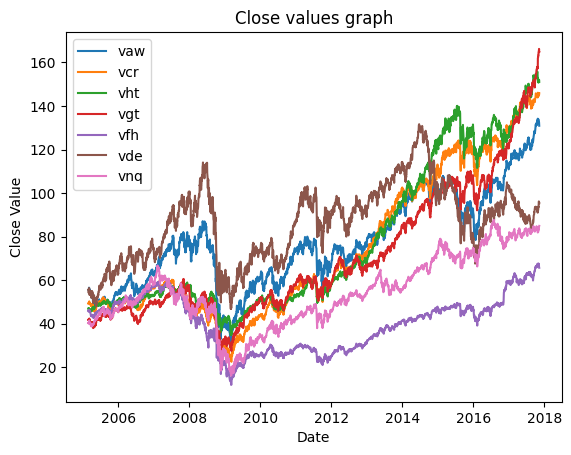

In [8]:
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vaw'], label='vaw')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vcr'], label='vcr')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vht'], label='vht')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vgt'], label='vgt')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vfh'], label='vfh')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vde'], label='vde')
plt.plot(pd.to_datetime(data['Date_vaw']), data['Close_vnq'], label='vnq')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Close values graph')
plt.legend()
plt.show()

In [9]:
data.rename(columns={'Date_vaw': 'Date'}, inplace=True)
data.index = data['Date']
data.pop('Date')
Train = data[:2560]
Test = data[2560:]
print(Train.shape)
print(Test.shape)
print(len(Test))

(2560, 35)
(641, 35)
641


In [10]:
import numpy as np

# Compute mean and std across samples and time steps for each feature
mean = np.mean(Train, axis=(0))
std = np.std(Train, axis=(0))
std[std == 0] = 1  # Prevent division by zero

# Normalize training data
Train_normalized = (Train - mean) / std

# Normalize test data
# Assuming you have test data: X_test, Y_test
Test_normalized = (Test - mean) / std

In [11]:
mode_list = ['multi', 'single']
ETF = ['vaw', 'vcr', 'vgt', 'vfh', 'vde', ' vht', 'vnq']

In [12]:
mode = 'multi'
ETF_active = ETF[0];
fragment_size = 10;
step = 1

if (mode == mode_list[0]):
  Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size] for i in range(0, len(Train_normalized) - fragment_size, step)]
  Train_Labels = [Train_normalized.iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Train_normalized), step)]

  Test_Fragmented = [Test_normalized .iloc[i:i + fragment_size] for i in range(0, len(Test_normalized ) - fragment_size, step)]
  Test_Labels = [Test_normalized .iloc[i][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']] for i in range(fragment_size, len(Test_normalized ), step)]
else:
  Train_Fragmented = [Train_normalized.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Train_normalized) - fragment_size, step)]
  Train_Labels = [Train_normalized.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Train_normalized), step)]

  Test_Fragmented = [Test.iloc[i:i + fragment_size][['Open_'  + ETF_active,'High_' + ETF_active,'Low_'  + ETF_active,'Close_'  + ETF_active,'Volume_'  + ETF_active]] for i in range(0, len(Test_normalized ) - fragment_size, step)]
  Test_Labels = [Test.iloc[i][['Close_'  + ETF_active]] for i in range(fragment_size, len(Test_normalized ), step)]


In [13]:
# Print dimensions for verification
print(f'Number of Train Fragments: {len(Train_Fragmented)}')
print(f'Number of Train Labels: {len(Train_Labels)}')
print(f'Number of Test Fragments: {len(Test_Fragmented)}')
print(f'Number of Test Labels: {len(Test_Labels)}')


Number of Train Fragments: 2550
Number of Train Labels: 2550
Number of Test Fragments: 631
Number of Test Labels: 631


In [14]:
#Print start and end of training and test data for verification
print(f'\nTraining data\n')
print(Train_Fragmented[1]['Close_' + ETF_active])
print(Train_Labels[1])
print(Train_Fragmented[2]['Close_' + ETF_active])
print(Train_Labels[2])

print(Train_Fragmented[2548]['Close_' + ETF_active])
print(Train_Labels[2548])
print(Train_Fragmented[2549]['Close_' + ETF_active])
print(Train_Labels[2549])

print(f'\nTest data\n')
print(Test_Fragmented[0]['Close_' + ETF_active])
print(Test_Labels[0])
print(Test_Fragmented[1]['Close_' + ETF_active])
print(Test_Labels[1])

print(Test_Fragmented[629]['Close_' + ETF_active])
print(Test_Labels[629])
print(Test_Fragmented[630]['Close_' + ETF_active])
print(Test_Labels[630])


Training data

Date
2005-02-28   -0.906491
2005-03-01   -0.910282
2005-03-02   -0.912947
2005-03-03   -0.910756
2005-03-04   -0.823515
2005-03-07   -0.847857
2005-03-08   -0.862604
2005-03-09   -0.864085
2005-03-10   -0.911822
2005-03-11   -0.887539
Name: Close_vaw, dtype: float64
Close_vaw   -0.894942
Close_vcr   -0.542463
Close_vgt   -0.965319
Close_vfh    0.735077
Close_vde   -1.652162
Close_vht   -0.750104
Close_vnq   -0.677831
Name: 2005-03-14, dtype: float64
Date
2005-03-01   -0.910282
2005-03-02   -0.912947
2005-03-03   -0.910756
2005-03-04   -0.823515
2005-03-07   -0.847857
2005-03-08   -0.862604
2005-03-09   -0.864085
2005-03-10   -0.911822
2005-03-11   -0.887539
2005-03-14   -0.894942
Name: Close_vaw, dtype: float64
Close_vaw   -0.903293
Close_vcr   -0.532480
Close_vgt   -0.984028
Close_vfh    0.728375
Close_vde   -1.691771
Close_vht   -0.771310
Close_vnq   -0.681605
Name: 2005-03-15, dtype: float64
Date
2015-04-14    2.004853
2015-04-15    2.059934
2015-04-16    2.035651
20

Date
2015-05-07    2.096062
2015-05-08    2.180756
2015-05-11    2.158250
2015-05-12    2.097839
2015-05-13    2.100208
2015-05-14    2.171872
2015-05-15    2.184902
2015-05-18    2.178979
2015-05-19    2.145812
2015-05-20    2.142851
Name: Close_vaw, dtype: float64
Date
2015-05-08    2.180756
2015-05-11    2.158250
2015-05-12    2.097839
2015-05-13    2.100208
2015-05-14    2.171872
2015-05-15    2.184902
2015-05-18    2.178979
2015-05-19    2.145812
2015-05-20    2.142851
2015-05-21    2.162396
Name: Close_vaw, dtype: float64


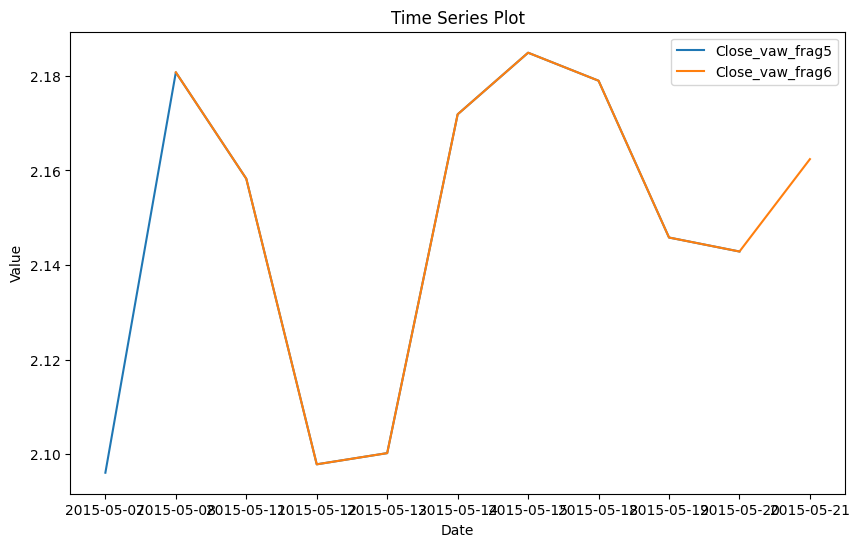

In [15]:
print(Test_Fragmented[5]['Close_' + ETF_active])
print(Test_Fragmented[6]['Close_' + ETF_active])
# Plot the time series data using Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(Test_Fragmented[5].index, Test_Fragmented[5]['Close_' + ETF_active], label='Close_'  + ETF_active + '_frag5')
plt.plot(Test_Fragmented[6].index, Test_Fragmented[6]['Close_' + ETF_active], label='Close_'  + ETF_active + '_frag6')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Plot')
plt.legend()
plt.show()

In [16]:
# Define module encapsulating a Sequence Classifier using RNN or LSTMs and setting different architecture hyper-parameters
class Simple_LSTM(nn.Module):
  def __init__(self,
               input_size : int = 5,
               hidden_size : int = 64,
               output_size : int = 1,
               num_layers : int =  5,
               activation_function = nn.Softmax(dim = 1)):  #softmax activation function in order to get multiclass probability
    # Define RNN or LSTM architecture
    super().__init__()
    self.rnn =  nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                          num_layers=num_layers, batch_first = True)

    self.activation_function = activation_function

    self.last_linear = nn.Linear(hidden_size,output_size)

  def forward(self, X):
    _,last_states = self.rnn(X)
    # Get last hidden state for last layer. Ignore cell state in case of LSTMs
    last_hidden_state = last_states[0][-1, :, :]
    # Get sequence label probability using the last hidden state
    next_prediction = self.last_linear(last_hidden_state)
    return next_prediction


In [17]:
def train_simple_LSTM(X_train, Y_train, model, optimizer, loss_func, epochs=100):
    loss_its = []
    for iter in range(epochs):
      optimizer.zero_grad()
      output = model(X_train)
      loss = loss_func(output,Y_train)
      loss_its.append(loss.item())
      loss.backward()
      optimizer.step()
    print(f'Final loss: {loss.item()}')
    return np.asarray(loss_its)

In [18]:
import torch
import torch.nn as nn

class Encoder_LSTM(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embedding_dim: int,
                 input_size: int,
                 hidden_size: int,
                 output_size: int,
                 num_layers: int = 5,
                 activation_function=nn.Softmax(dim=1)):
        super(Encoder_LSTM, self).__init__()

        # Define embedding layer
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        # Define activation function
        self.activation_function = activation_function

        # Define the final linear layer
        self.last_linear = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        # Encode the input sequences
        embedded = self.embedding(X)

        # Pass through LSTM
        _, (last_hidden_state, _) = self.lstm(embedded)

        # Get last hidden state for last layer
        last_hidden_state = last_hidden_state[-1, :, :]

        # Get sequence label probability using the last hidden state
        next_prediction = self.last_linear(last_hidden_state)
        next_prediction = self.activation_function(next_prediction)

        return next_prediction

# Example usage
# vocab_size = 5000  # Size of vocabulary
# embedding_dim = 50  # Dimension of embedding vectors
# input_size = embedding_dim  # Input size to LSTM (should match embedding_dim)
# hidden_size = 20  # Number of hidden units in LSTM
# output_size = 6  # Number of output classes
# num_layers = 5  # Number of LSTM layers

# model = Encoder_LSTM(vocab_size, embedding_dim, input_size, hidden_size, output_size, num_layers)
# print(model)


In [19]:

import numpy as np
import random
import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F


class lstm_encoder(nn.Module):
    ''' Encodes time-series sequence '''

    def __init__(self, input_size, hidden_size, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''

        super(lstm_encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # define LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)

    def forward(self, x_input):

        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence;
        :                              hidden gives the hidden state and cell state for the last
        :                              element in the sequence
        '''

        lstm_out, self.hidden = self.lstm(x_input.view(x_input.shape[0], x_input.shape[1], self.input_size))

        return lstm_out, self.hidden

    def init_hidden(self, batch_size):

        '''
        initialize hidden state
        : param batch_size:    x_input.shape[1]
        : return:              zeroed hidden state and cell state
        '''

        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))


class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''

    def __init__(self, input_size, hidden_size, num_layers = 1):

        '''
        : param input_size:     the number of features in the input X
        : param hidden_size:    the number of features in the hidden state h
        : param num_layers:     number of recurrent layers (i.e., 2 means there are
        :                       2 stacked LSTMs)
        '''

        super(lstm_decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)

    def forward(self, x_input, encoder_hidden_states):

        '''
        : param x_input:                    should be 2D (batch_size, input_size)
        : param encoder_hidden_states:      hidden states
        : return output, hidden:            output gives all the hidden states in the sequence;
        :                                   hidden gives the hidden state and cell state for the last
        :                                   element in the sequence

        '''

        lstm_out, self.hidden = self.lstm(x_input.unsqueeze(0), encoder_hidden_states)
        output = self.linear(lstm_out.squeeze(0))

        return output, self.hidden

class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''

    def __init__(self, input_size, hidden_size):

        '''
        : param input_size:     the number of expected features in the input X
        : param hidden_size:    the number of features in the hidden state h
        '''

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = lstm_encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = lstm_decoder(input_size = input_size, hidden_size = hidden_size)


    def train_model(self, input_tensor, target_tensor, n_epochs, target_len, batch_size, training_prediction = 'recursive', teacher_forcing_ratio = 0.5, learning_rate = 0.01, dynamic_tf = False):

        '''
        train lstm encoder-decoder

        : param input_tensor:              input data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param target_tensor:             target data with shape (seq_len, # in batch, number features); PyTorch tensor
        : param n_epochs:                  number of epochs
        : param target_len:                number of values to predict
        : param batch_size:                number of samples per gradient update
        : param training_prediction:       type of prediction to make during training ('recursive', 'teacher_forcing', or
        :                                  'mixed_teacher_forcing'); default is 'recursive'
        : param teacher_forcing_ratio:     float [0, 1) indicating how much teacher forcing to use when
        :                                  training_prediction = 'teacher_forcing.' For each batch in training, we generate a random
        :                                  number. If the random number is less than teacher_forcing_ratio, we use teacher forcing.
        :                                  Otherwise, we predict recursively. If teacher_forcing_ratio = 1, we train only using
        :                                  teacher forcing.
        : param learning_rate:             float >= 0; learning rate
        : param dynamic_tf:                use dynamic teacher forcing (True/False); dynamic teacher forcing
        :                                  reduces the amount of teacher forcing for each epoch
        : return losses:                   array of loss function for each epoch
        '''

        # initialize array of losses
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iterations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:

                batch_loss = 0.
                batch_loss_tf = 0.
                batch_loss_no_tf = 0.
                num_tf = 0
                num_no_tf = 0

                for b in range(n_batches):
                    # select data
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    if training_prediction == 'recursive':
                        # predict recursively
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output
                            decoder_input = decoder_output

                    if training_prediction == 'teacher_forcing':
                        # use teacher forcing
                        if random.random() < teacher_forcing_ratio:
                            for t in range(target_len):
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = target_batch[t, :, :]

                        # predict recursively
                        else:
                            for t in range(target_len):
                                decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                                outputs[t] = decoder_output
                                decoder_input = decoder_output

                    if training_prediction == 'mixed_teacher_forcing':
                        # predict using mixed teacher forcing
                        for t in range(target_len):
                            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                            outputs[t] = decoder_output

                            # predict with teacher forcing
                            if random.random() < teacher_forcing_ratio:
                                decoder_input = target_batch[t, :, :]

                            # predict recursively
                            else:
                                decoder_input = decoder_output

                    # compute the loss
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch
                batch_loss /= n_batches
                losses[it] = batch_loss

                # dynamic teacher forcing
                if dynamic_tf and teacher_forcing_ratio > 0:
                    teacher_forcing_ratio = teacher_forcing_ratio - 0.02

                # progress bar
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))

        return losses

    def predict(self, input_tensor, target_len):

        '''
        : param input_tensor:      input data (seq_len, input_size); PyTorch tensor
        : param target_len:        number of target values to predict
        : return np_outputs:       np.array containing predicted values; prediction done recursively
        '''

        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden

        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output

        np_outputs = outputs.detach().numpy()

        return np_outputs


In [20]:
tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Fragmented]
X_train = torch.stack(tensor_list)
label_tensor_list = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Train_Labels]
Y_train =  torch.stack(label_tensor_list)

tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Fragmented]
X_test = torch.stack(tensor_list_test)
label_tensor_list_test = [torch.tensor(fragment.values, dtype=torch.float32) for fragment in Test_Labels]
Y_test =  torch.stack(label_tensor_list_test)

In [24]:

# Define hyperparameters
input_size = len(tensor_list) # Number of features in input data
hidden_size = 64  # Number of features in the hidden state

# Instantiate the model
model = lstm_seq2seq(input_size, hidden_size)

# Define training parameters
n_epochs = 10
target_len = 10
batch_size = 32
training_prediction = 'recursive'
teacher_forcing_ratio = 0.5
learning_rate = 0.01
dynamic_tf = False

# Train the model
losses = model.train_model(X_train, Y_train, n_epochs, target_len, batch_size,
                            training_prediction, teacher_forcing_ratio, learning_rate, dynamic_tf)


  0%|          | 0/10 [00:00<?, ?it/s]


ZeroDivisionError: float division by zero

In [ ]:
X_train_pt = X_train.float().cuda()
Y_train_pt = Y_train.float().cuda()
X_test_pt = X_test.float().cuda()
Y_test_pt = Y_test.float().cuda()

print(X_train.shape)
print(Y_train.shape)

# Histogram

In [ ]:
Y_predicted = model(X_test_pt).cpu().detach().numpy()
Y = Test_normalized[fragment_size:][['Close_vaw','Close_vcr','Close_vgt','Close_vfh','Close_vde','Close_vht','Close_vnq']]
Y = Y.to_numpy()
print(Y_predicted)

In [ ]:
file_path = os.path.join(myDrive,'Y_predicted.csv')
pd.DataFrame(Y_predicted).to_csv(file_path, index=False)

In [ ]:
import matplotlib.pyplot as plt

# Example arrays for Y_predicted and Y
# Ensure these are defined as per your actual data
# Y_predicted = np.random.randn(640, 6)  # Example: If Y_predicted is a 2D array
# Y = np.random.randn(640, 6, 1)  # Example: If Y is a 3D array

# Ensure `Y` is 2D by squeezing the last dimension
Y_squeezed = Y.squeeze()

# Check the shapes (for debugging purposes)
print("Y_predicted shape:", Y_predicted.shape)
print("Y shape after squeezing:", Y_squeezed.shape)

# Plot the actual signals
plt.figure(figsize=(12, 8))
if Y_squeezed.ndim == 2:
  for i in range(Y_squeezed.shape[1]):
      plt.plot(Y_squeezed[:, i], label=f"Actual Signal {i+1}")
else:
  plt.plot(Y_squeezed[:], label=f"Actual Signal {1}")

# Ensure Y_predicted is compatible for plotting
if Y_predicted.shape[1] == 1:
    # If Y_predicted is 1D, we plot it directly
    plt.plot(Y_predicted, label="Predicted Signal", linestyle='--')
elif Y_predicted.ndim == 2 and Y_predicted.shape[1] == Y_squeezed.shape[1]:
    # If Y_predicted is 2D, plot each predicted signal
    for i in range(Y_predicted.shape[1]):
        plt.plot(Y_predicted[:, i], linestyle='--', label=f"Predicted Signal {i+1}")

plt.title('Overlayed 6 Signals with 256 Samples Each')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(Y_predicted)
plt.plot(Y)
plt.title('Overlayed 6 Signals with 256 Samples Each')
plt.xlabel('Sample Index')
plt.ylabel('Signal Value')
plt.legend()
plt.grid(True)
plt.show()